Packages à installer

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import romberg
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Définition des classes

In [2]:
class Plant: 
    objs =[]
    
    def __init__(self, ID_nb, ID_plant_species, ID_chambre_culture):
        Plant.objs.append(self)
        self.ID_nb = ID_nb
        self.ID_plant_species = ID_plant_species
        self.ID_chambre_culture = ID_chambre_culture
        self.Fm = []
        self.Dm = []
        self.Cout = 0
    
    def Cost (self, prix, dt, conso_plante_unitaire):
        self.Cout += (prix/100)*(conso_plante_unitaire/1000)*(dt/60)
    
    @classmethod
    def link_objects (cls):
        for plant in cls.objs:
            for plant_species in Plant_species.objs:
                if plant.ID_plant_species == plant_species.ID_nb:
                    plant.plant_species = plant_species
                    plant.Dm.append(plant_species.Dm_0)
                    plant.Fm.append(plant_species.Fm_0)
            for chambre_culture in Chambre_culture.objs:
                if plant.ID_chambre_culture == chambre_culture.ID_nb:
                    plant.chambre_culture = chambre_culture
    
    @classmethod
    def resol_step (cls,prix_elec, pas_de_temps):
        for plant in Plant.objs:
            plant.Cost(prix_elec, pas_de_temps, plant.chambre_culture.conso_plante_unitaire)
            plant.Dm.append(plant.plant_species.dry_matter(plant.plant_species.dDmdt, plant.Dm[-1], pas_de_temps, plant.chambre_culture.PAR, plant.chambre_culture.temperature, plant.chambre_culture.CO2_air))
            plant.Fm.append(plant.plant_species.fresh_matter(plant.Dm[-1]))
    
    @classmethod
    def results (cls):
        Dm=[]
        Fm=[]
        Cout=[]
        Prix_kg=[]
        for plant in Plant.objs:
            Dm.append(plant.Dm[-1])
            Fm.append(plant.Fm[-1])
            Cout.append(plant.Cout)
            Prix_kg.append(plant.Cout/plant.Fm[-1])
        return Dm,Fm,Cout,Prix_kg
    
class Plant_species:
    objs = []
    
    def __init__(self, ID_nb, ID_chambre_culture, species, Dm_0, dDmdt, dry_matter, fresh_matter):
        Plant_species.objs.append(self)
        self.ID_nb = ID_nb
        self.species = species
        self.Dm_0 = Dm_0 #[g]
        self.Fm_0 = fresh_matter(Dm_0)
        self.dDmdt = dDmdt
        self.dry_matter = dry_matter
        self.fresh_matter = fresh_matter
    
class Chambre_culture:
    objs=[]
    
    def __init__(self, ID_nb, ID_LED, ID_alim, ID_scenario, surface, nb_LED, nb_plantes, CO2_air, temperature):
        Chambre_culture.objs.append(self)
        self.ID_nb = ID_nb
        self.ID_LED = ID_LED
        self.ID_alim =ID_alim
        self.ID_scenario =ID_scenario
        self.surface = surface #[m²]
        self.nb_LED = nb_LED
        self.nb_plantes = nb_plantes
        self.CO2_air = CO2_air
        self.temperature = temperature
        self.switch_LED = False
    
    @classmethod
    def link_objects (cls):
        for chambre_culture in cls.objs :
            for scenario in Scenario.objs :
                if chambre_culture.ID_scenario == scenario.ID_nb:
                    chambre_culture.scenario = scenario
            for led in LED.objs :
                if chambre_culture.ID_LED == led.ID_nb:
                    chambre_culture.LED = led
            for alim in Alim.objs :
                if chambre_culture.ID_alim == alim.ID_nb:
                    chambre_culture.alim = alim        
                    
    @classmethod 
    def resol_step  (cls, PPFD_voulu, heure):
        for room in cls.objs :
            if (heure > room.scenario.heure_debut and heure < room.scenario.heure_debut + room.scenario.photoperiode) or (room.scenario.heure_debut + room.scenario.photoperiode > 24 and heure < (room.scenario.heure_debut +room.scenario.photoperiode-24)):
                room.switch = True
            else :
                room.switch = False
            flux_led = (PPFD_voulu*room.surface)/(room.LED.umol_nom * room.nb_LED)
            I_voulu = room.LED.I_flux(flux_led)
            room.conso= (room.nb_LED * room.LED.P_I(I_voulu)*room.switch)/room.alim.rendement
            room.PAR= room.LED.PAR_nom * room.nb_LED * flux_led * room.switch 
            room.conso_plante_unitaire =  room.conso / room.nb_plantes
        
class Scenario: 
    objs=[]
    
    def __init__(self,ID_nb, heure_debut, photoperiode):
        Scenario.objs.append(self)
        self.ID_nb =ID_nb
        self.heure_debut=heure_debut #heure d'activation de l'éclairage 
        self.photoperiode= photoperiode #photopériode en heure
    
class LED:
    objs=[]
    
    def __init__(self, ID_nb, umol_nom, PAR_nom, I_flux, P_I):
        LED.objs.append(self)
        self.ID_nb = ID_nb
        self.umol_nom = umol_nom 
        self.PAR_nom = PAR_nom
        self.I_flux = I_flux 
        self.P_I = P_I

class Alim:
    objs=[]
    
    def __init__(self, ID_nb, rendement):
        Alim.objs.append(self)
        self.ID_nb = ID_nb
        self.rendement = rendement

Défintion d'une fonction calculant les paramètres des LED

In [3]:
def calc_LED ():
    
    #importation de la courbe spectrale du nombre relatif de photons émis en fonctions de la longueur d'onde
    #création d'une courbe d'interpolation 
    #calcul du nombre de photons émis en intégrant la courbe d'émission spectrale 
    #nombre de photons obtenus = nombre de photons émis par un LED ayant un pic d'émissions d'1 µmol à 630nm
    data_spec_phot_flux = pd.read_csv('LED/spectral photon flux.csv',delimiter = ';', header = 0, decimal = ',')
    spec_phot_flux = interp1d (data_spec_phot_flux.iloc[:,0], data_spec_phot_flux.iloc[:,2], kind = 'cubic')
    I= romberg(spec_phot_flux,400,780, divmax = 20)
    
    #calcul du nombre de photons émis par le LED pour un courant de 700mA 
    nb_lumen_umol = 52.56 #[lumen/umol photon/s] intensité lumineuse d'1 µmol de photons
    intensite_lumineuse_led = 192 #[lumen] intensité lumineuse à 700mA
    umol_led = intensite_lumineuse_led/nb_lumen_umol #[µmol de photon/s] quantité de photons émis par seconde
    
    #Calcul du nombre de photons émis par 1 LED à 700mA    
    f = umol_led/I #rapport entre la quantité émise par l'ampoule LED considérée et celle émise par l'ampoule standard
    Na = 6.022 * 10**(23)#[entité par mol] nombre d'AVOGADRO
    phot_emis= data_spec_phot_flux.iloc [:,2]*f*Na*10**(-6) #courbe donnant le nombre de photons émis par la LED en fonction de la longeur d'onde
    
    #calcul de l'énergie d'irradiance de chaque photons émis
    h = 6.63*10**(-34) #constante de Planck [J.s]
    c = 3*10**(8) #vitesse de la lumière [m/s]
    
    #création d'une courbe donnant l'énergie d'irradiance émise par la LED en fonction de la longueur d'onde
    en_emis=[]
    for i in np.arange (len(data_spec_phot_flux.iloc[:,0])):
        en_emis.append ((phot_emis [i]*h*c)/(data_spec_phot_flux.iloc[i,0]*10**(-9)))
    en_emis_lambda = interp1d (data_spec_phot_flux.iloc[:,0],en_emis,kind ='cubic')
    
    #calcul du rayonnement photosynthétiquement actif [W] en intégrant cette courb entre 400 et 700nm  
    PAR = romberg (en_emis_lambda,400,700, divmax = 20)
    
    #on renvoie  le nombre de umol émis par seconde et le PAR émis par seconde
    return umol_led,PAR

Modèle de croissance et caractéristiques de l'espèce végétale modélisée (ici la laitue)

In [4]:
lettuce_Dm_0 = 1*10**(-3)# masse d'une graine de laitue [g]

def lettuce_dDmdt (Dm, t, T, CO2_air, PAR): 
    #équation différentielle exprimant la dérivée temporelle de la masse sèche d'une laitue en fonction des conditions extérieures
    #définition des constantes et des paramètres
    c_alpha = 0.68 #[-]
    c_bheta = 0.8 #[-]
    c_bnd = 0.004 #[-]
    c_car1 = -1.32 * 10**(-5) #[m/s.°C²]
    c_car2 = 5.94*10**(-4)#[m/s.°C]
    c_car3 =-2.64*10**(-3)#[m/s]
    c_eps = 17*10**(-9)#[kg/J]
    c_T = 7.32 * 10**(-5)#[kg/m³]
    c_k = 0.9 #[-]
    c_lar_d = 62.5#[m²/kg]
    c_Q10_T = 2 #[-]
    c_Q10_resp = 2 #[-]
    c_resp_s = 3.47*10**(-7)#[s-1]
    c_resp_r = 1.16*10**(-7)#[s-1]
    c_stm = 0.007 #[m/s]
    c_t = 0.07 #[-]
    #calcul de la résistance de la carboxylation [m/s]
    sigma_car = c_car1*T**(2)+c_car2*T+c_car3
    #calcul de la conductance lumineuse de la canopée [m/s]
    sigma_co2 = ((1/c_bnd)+(1/c_stm)+(1/sigma_car))**(-1)      
    #calcul du point de compensation du CO2 [kg/m³]
    Gam = c_T*c_Q10_T**((T-20)/10)
    #Calcul du light use efficiency de la photosynthèse [kg/J]
    eps = c_eps*((CO2_air-Gam)/(CO2_air+2*Gam))
    #calcul du taux maximal d'assimilation photosynthétique [kg/m².s]
    P_max = (eps*PAR*sigma_co2*(CO2_air-Gam))/(eps*PAR+sigma_co2*(CO2_air-Gam))
    #calcul du taux de respiration [kg/m².s]
    R = (c_resp_s *(1-c_t)+ c_resp_r*c_t)* Dm*c_Q10_resp**(0.1*T - 2.5)
    #calcul du taux d'assimilation photosynthétique [kg/m².s]
    P = P_max *(1-np.exp(-c_k*c_lar_d*(1-c_t)*Dm))
    #calcul de la dérivée de la masse sèche d'une plante au cours du temps [kg/s]
    dDmdt = c_bheta *(c_alpha * P - R)/18 #18 est le nombre de plante par m² implémenté dans le modèle utilisé
    return dDmdt
    
def lettuce_fresh_matter (Dm):
    #calcul de la masse de matière fraiche d'une laitue [kg/m²] en fonction de sa matière sèche    
    c_fw = 22.5#[-]
    c_t = 0.07 #[-]
    Fm = c_fw*Dm*(1-c_t)
    return Fm
    
def lettuce_dry_matter (dDmdt, Dm_0, dt, PAR, T, CO2_air):
    #calcul de la masse de matière sèche finale d'une laitue ayant une masse sèche initiale Dm_0
    #soumise à une température T,un rayonnement photosynthétiquement actif PAR et une concentration de CO2 CO2_air
    #sur un intervalle de temps dt 
    tspan=[0,dt*60]
    Dm_cur = odeint (dDmdt, Dm_0, tspan, args= ( T, CO2_air, PAR,) )
    Dm = Dm_cur[-1]
    return Dm

Défintion des paramètres des objets constituants le système

In [5]:
#paramètres chambre de culture 
temperature = 23 #[°C]
CO2_air = 5*10**(-2) #[kg/m³]
nb_led_room = 65 #nombre de LED dans une chambre de culture
nb_plante_room = 20 # nombre de plante dans la chambre de culture
surface = 1 #m² 

#paramètres alimentation 
rendement_alim = 0.85

#paramètres scenario
heure_debut = 20
photoperiode = 16 #h 

#paramètres LED
[umol_nom_OSRAM_GW_CSSRM1, PAR_nom_OSRAM_GW_CSSRM1] = calc_LED()
csv_courbe_flux_relatif_vs_courant = 'LED/flux relatif vs courant.csv'
csv_courant_vs_tension = 'LED/courant tension.csv'
dat_flux_I = pd.read_csv(csv_courbe_flux_relatif_vs_courant,delimiter = ';', header = 0, decimal = ',') 
OSRAM_GW_CSSRM1_I_flux = interp1d (dat_flux_I.iloc[:,1], dat_flux_I.iloc[:,0], kind = 'cubic')
dat_I_V_P = pd.read_csv(csv_courant_vs_tension,delimiter = ';', header = 0, decimal = ',') 
OSRAM_GW_CSSRM1_P_I = interp1d (dat_I_V_P.iloc[:,1], dat_I_V_P.iloc[:,2], kind = 'cubic')


Paramètres de la simulation désirée

In [6]:
nb_jour = 50
pas_de_temps = 15 #minutes
type_simulation = 'simple'
price_adaptation = True
periode_regulation = 'journée'
PPFD_nom = 300 #µmol photons/m².s
PPFD_max = 500
PPFD_min = 100

Définition d'une fonction ajustant la quantité de photons envoyée aux plantes au prix de l'électricité 

In [7]:
if price_adaptation == True:
    def ajust_conso(prix ,prix_max , prix_min, PPFD_max, PPFD_min):
        m = (PPFD_min - PPFD_max)/(prix_max-prix_min)
        p = PPFD_max-m*prix_min
        PPFD= m*prix + p
        return PPFD
    
elif price_adaptation == False:
    def ajust_conso(prix ,prix_max , prix_min, PPFD_max, PPFD_min):
        PPFD = PPFD_nom
        return PPFD

Création des objets du système sur base de la simulation voulue et des paramètres sélectionnés pour les objets du système

In [8]:
if type_simulation == 'simple':
    lettuce_1= Plant(1,1,1)
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    chambre_culture_1= Chambre_culture(1,1,1,1, surface, nb_led_room, nb_plante_room, CO2_air, temperature)
    LED_1 =LED(1, umol_nom_OSRAM_GW_CSSRM1, PAR_nom_OSRAM_GW_CSSRM1, OSRAM_GW_CSSRM1_I_flux, OSRAM_GW_CSSRM1_P_I)
    alim_1 = Alim(1,rendement_alim)
    scenario_1 =Scenario (1,heure_debut,photoperiode)
    
elif type_simulation == 'effet heure de debut':
    for i in np.arange (24):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+")")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,"+str(i)+", surface, nb_led_room, nb_plante_room, CO2_air, temperature)")
        exec ("scenario_"+str(i)+" =Scenario ("+str(i)+","+str(i)+",photoperiode)")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom_OSRAM_GW_CSSRM1, PAR_nom_OSRAM_GW_CSSRM1, OSRAM_GW_CSSRM1_I_flux, OSRAM_GW_CSSRM1_P_I)
    alim_1 = Alim(1,rendement_alim)

elif type_simulation =='effet température':
    for i in np.arange (29):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+")")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,1, surface, nb_led_room, nb_plante_room, CO2_air, 7 +"+str(i)+")")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom_OSRAM_GW_CSSRM1, PAR_nom_OSRAM_GW_CSSRM1, OSRAM_GW_CSSRM1_I_flux, OSRAM_GW_CSSRM1_P_I)
    alim_1 = Alim(1,rendement_alim)
    scenario_1 =Scenario (1,heure_debut,photoperiode)

elif type_simulation == 'effet photopériode':
    for i in np.arange (24):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+")")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,"+str(i)+", surface, nb_led_room, nb_plante_room, CO2_air, temperature)")
        exec ("scenario_"+str(i)+" =Scenario ("+str(i)+", heure_debut,"+str(i)+")")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom_OSRAM_GW_CSSRM1, PAR_nom_OSRAM_GW_CSSRM1, OSRAM_GW_CSSRM1_I_flux, OSRAM_GW_CSSRM1_P_I)
    alim_1 = Alim(1,rendement_alim)

Chambre_culture.link_objects()
Plant.link_objects()

Importation des données de prix de l'électricité

In [9]:
prix = pd.read_csv('prix_elec/DA prices BE NL 2018-2019.csv', delimiter = ';' ,header = 0)
prix.iloc[:,0] =pd.to_datetime(prix.iloc[:,0])

Initialisation de la simulation

In [10]:
if periode_regulation =='journée':
    n = (24*4)-1
elif periode_regulation =='semaine':
    n = (7*24*4)-1
elif periode_regulation =='mois':
    n = (30*24*4)-1
prix_last_day = prix.iloc[0:n,5]
prix_min = min(prix_last_day)
prix_max = max(prix_last_day)
first_in = 0

Simulation de la croissance et du cout des plantes sur la période considérée

In [11]:
for j in np.arange(nb_jour*24*4):
    prix_cour = prix.iat[j,5]
    prix_last_day [first_in] = prix_cour
    prix_min = min(prix_last_day)
    prix_max = max(prix_last_day)   
    if first_in == len(prix_last_day):
        first_in = 0
    else:
        first_in +=1        
    PPFD_voulu = ajust_conso(prix_cour ,prix_max , prix_min, PPFD_max, PPFD_min)
    heure = prix.iat[j,0].hour

    Chambre_culture.resol_step(PPFD_voulu, heure)
    Plant.resol_step(prix_cour,pas_de_temps)

[Dm,Fm,Cout,Prix_kg]=Plant.results()

Représentation graphique des résultats obtenus 

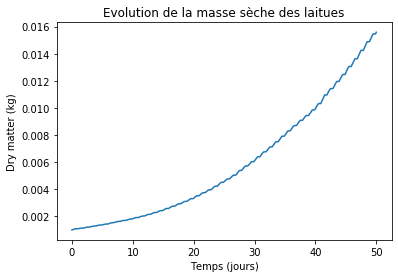

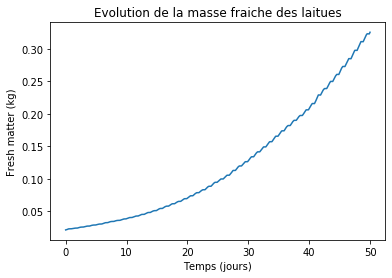

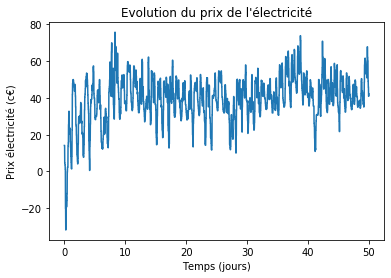

In [12]:
if type_simulation == 'simple':
    plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),lettuce_1.Dm[:])
    plt.xlabel('Temps (jours)')
    plt.ylabel('Dry matter (kg)')
    plt.title ('Evolution de la masse sèche des laitues')
    plt.show()
    plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),lettuce_1.Fm[:])
    plt.xlabel('Temps (jours)')
    plt.ylabel('Fresh matter (kg)')
    plt.title ('Evolution de la masse fraiche des laitues')
    plt.show()
    plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),prix.iloc[0:((nb_jour*24*4)+1),5])
    plt.xlabel('Temps (jours)')
    plt.ylabel('Prix électricité (c€)')
    plt.title ("Evolution du prix de l'électricité")
    plt.show()

elif type_simulation =='effet heure de debut':
    plt.plot(np.arange(24),Cout)
    plt.xlabel('Heure de début')
    plt.ylabel('Prix (€)')
    plt.title ("Prix des laitues en fonction de l'heure de début d'éclairage")
    plt.show()
    plt.plot(np.arange(24),Fm)
    plt.xlabel('Heure de début')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de l'heure de début d'éclairage")
    plt.show()
    plt.plot(np.arange(24),Prix_kg)
    plt.xlabel('Heure de début')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de l'heure de début d'éclairage")
    plt.show()
    
elif type_simulation =='effet température':
    plt.plot(7+np.arange(len(Fm)),Fm)
    plt.xlabel('Température(°C)')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de la température de culture")
    plt.show()
    plt.plot(7+np.arange(len(Fm)),Prix_kg)
    plt.xlabel('Température(°C)')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de la température de culture")
    plt.show()
    
elif type_simulation =='effet photopériode':
    plt.plot(np.arange(24),Cout)
    plt.xlabel('Photopériode (h)')
    plt.ylabel('Prix (€)')
    plt.title ("Prix des laitues en fonction de la durée de la photopériode")
    plt.show()
    plt.plot(np.arange(24),Fm)
    plt.xlabel('Photopériode (h)')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de la durée de la photopériode")
    plt.show()
    plt.plot(np.arange(24),Prix_kg)
    plt.xlabel('Photopériode (h)')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de la durée de la photopériode")
    plt.show()